In [14]:
import pandas as pd
from random import sample
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# import scipy.stats as ss
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import CubicSpline
from astropy.cosmology import FlatLambdaCDM
from tqdm import tqdm
# import time
# import astropy.units as u
# import astropy.cosmology.units as cu
# from astropy.cosmology import z_at_value
# import bz2
import os
import copy
# import glob
# import emcee
# import corner
# from scipy.interpolate import interp1d

import gwfast.gwfastGlobals as glob
from gwfast.waveforms import IMRPhenomD_NRTidalv2, TaylorF2_RestrictedPN, IMRPhenomD
from gwfast.signal import GWSignal
from gwfast.network import DetNet
from fisherTools import CovMatr, compute_localization_region, check_covariance, fixParams

import jax

print("Available devices:", jax.devices())

# Ensure JAX is using GPU
assert any(device.platform == "gpu" for device in jax.devices()), "GPU is not being used!"

Available devices: [cuda(id=0)]


In [2]:
%matplotlib inline

In [4]:
class GWSampler:
    def __init__(self, host_g = pd.DataFrame({})):
        """Initialization"""
        self.host_g = host_g

        self.BNS  = pd.DataFrame({})
        self.BBH  = pd.DataFrame({})
        self.NSBH = pd.DataFrame({})

    # Mass distributions
    def stepf(self, m1,Mmin,Mmax, val1 = 0, val2 = 0):
      return np.heaviside(m1-Mmin, val1) * np.heaviside(Mmax - m1, val2)

    def ff(self,m,delta):
      return (1 + np.exp(delta/m + delta/(m - delta)))**(-1)

    def Smoothf(self,m1,Mmin,delta):
      filtr1 = m1 > Mmin
      filtr2 = m1 < Mmin + delta
      filtr3 = np.logical_and(filtr1,filtr2)

      res = np.concatenate([np.zeros(np.sum(~filtr1)),
                            self.stepf(m1[filtr3],Mmin,Mmin+delta) * self.ff(m1[filtr3]-Mmin,delta),
                            np.ones(np.sum(~filtr2))])
      return res

    def trunc_plaw(self,m1,Mmin,Mmax,alpha,val1 = 0, val2 = 0):
      return self.stepf(m1,Mmin,Mmax,val1,val2) * m1**(-alpha)

    def broken_plaw(self,m1,Mmin,Mmax,alpha1,alpha2,b,delta_m):
      m_break = Mmin + b * (Mmax - Mmin)
      return self.trunc_plaw(m1,Mmin,m_break,alpha1) + self.trunc_plaw(m1,m_break,Mmax,alpha2) * self.trunc_plaw(m_break,Mmin,m_break,alpha1,val2=1) / self.trunc_plaw(m_break,m_break,Mmax,alpha2,val1=1)
      # return Smoothf(m1,Mmin,delta_m) * (stepf(m1,Mmin,m_break,val2=1) * m1**(-alpha1) + stepf(m1,m_break,Mmax) * m1**(-alpha2))

    def gaussian_plaw(self,m1,Mmin,Mmax,alpha,mu,sigma,lam,delta_m):
      ys = self.Smoothf(m1,Mmin,delta_m) * self.stepf(m1,Mmin,Mmax) * ((1 - lam) * self.trunc_plaw(m1,Mmin,Mmax,alpha) + lam * norm(loc = mu, scale = sigma).pdf(m1))
      return np.where(ys > 1e-16, ys, 0)

    def multipeak_plaw(self,m1,Mmin,Mmax,alpha,mu,sigma,lam,delta_m,mu_l,sigma_l,lam_l):
      return self.Smoothf(m1,Mmin,delta_m) * self.stepf(m1,Mmin,Mmax) * ((1 - lam) * self.trunc_plaw(m1,Mmin,Mmax,alpha) + lam * (1 - lam_l) * norm(loc = mu, scale = sigma).pdf(m1) + lam * lam_l * norm(loc = mu_l, scale = sigma_l).pdf(m1))

    # def pm2(m2,Mmin,m1,beta):
    #   return trunc_plaw(m2,Mmin,m1,-beta)
    # Taken from pycbc documentation https://pycbc.org/pycbc/latest/html/_modules/pycbc/conversions.html
    def eta(self, mass1, mass2):
        """Returns the symmetric mass ratio from mass1 and mass2."""
        return mass1*mass2 / (mass1 + mass2)**2.

    def mchirp(self, mass1, mass2):
        """Returns the chirp mass from mass1 and mass2."""
        return self.eta(mass1, mass2)**(3./5) * (mass1 + mass2)


    def sample_m(self, n = 1000, profile = 'gaussian', args = None):

        if args == None:
          if profile == 'trunc':
            profilef  = self.trunc_plaw
            args      = (1,100,1.5)

          elif profile == 'broken':
            profilef  = self.broken_plaw
            args      = (1,100,1,2,0.2,1)

          elif profile == 'gaussian':
            profilef  = self.gaussian_plaw
            args      = (2.5,100,3.4,35,3.9,0.04,4.8)

          elif profile == 'multipeak':
            profilef  = self.multipeak_plaw
            args      = (1,100,2,8,3,0.3,1,30,4,0.3)

        else:
          if profile == 'trunc':
            profilef  = self.trunc_plaw

          elif profile == 'broken':
            profilef  = self.broken_plaw

          elif profile == 'gaussian':
            profilef  = self.gaussian_plaw

          elif profile == 'multipeak':
            profilef  = self.multipeak_plaw


        Mmin, Mmax = args[:2]

        # Define the custom PDF
        def pdf(x):
            return profilef(x,*args)
            # return trunc_plaw(x,Mmin,Mmax,1.5)
            # return broken_plaw(x,Mmin,Mmax,alpha1 = 1,alpha2 = 2,b = 0.2, delta_m = 1)
            # return gaussian_plaw(x,Mmin,Mmax,alpha = 1,mu = 8,sigma = 3,lam = 0.9, delta_m = 0.5)
            # return multipeak_plaw(x,Mmin,Mmax,alpha = 2,mu = 8,sigma = 3,lam = 0.3,delta_m = 1,mu_l = 30,sigma_l = 4,lam_l = 0.3)


        # Create a grid for x
        m1 = np.geomspace(Mmin, Mmax, 1000000)

        # Compute the normalized CDF over the grid
        cdf_values = cumulative_trapezoid(pdf(m1), m1, initial=0)  # Integrate the PDF
        cdf_values /= cdf_values[-1]  # Normalize to make it a valid CDF
        fin_zero_ind = np.sum(cdf_values == 0) - 1
        cdf_values = cdf_values[fin_zero_ind:]
        m1 = m1[fin_zero_ind:]

        # Interpolate the inverse CDF using CubicSpline
        inverse_cdf = CubicSpline(cdf_values, m1, bc_type='clamped')

        # Generate uniform samples
        u_samples = np.random.uniform(0, 1, n)

        # Map uniform samples through the inverse CDF
        samples = inverse_cdf(u_samples)

        return samples
    

    def reset_samples(self):
      self.BNS  = pd.DataFrame({})
      self.BBH  = pd.DataFrame({})
      self.NSBH = pd.DataFrame({})

    def sample_BBH(self,n = 1000):
      
      if not self.host_g.empty:
        print('Change n to comply with host_g.')
        n = len(self.host_g)
        self.BBH = self.host_g.copy()
        # self.BBH['dL'] = self.host_g['dL'].copy()

      samples_m1 = self.sample_m(n = n)
      samples_m2 = np.random.uniform(low=2.5, high = samples_m1)
      self.BBH['m1'] = samples_m1
      self.BBH['m2'] = samples_m2

      # Add eta and Mchirp
      self.BBH['eta'] = self.eta(self.BBH['m1'],self.BBH['m2'])
      self.BBH['Mc']  = self.mchirp(self.BBH['m1'],self.BBH['m2'])

      # Add other parameters
      self.BBH['iota']     = np.arccos(np.random.uniform(-1., 1., n))
      self.BBH['psi']      = np.random.uniform(0., 2.*np.pi, n)
      self.BBH['tcoal']    = np.random.uniform(0., 1., n)
      self.BBH['Phicoal']  = np.random.uniform(0., 2.*np.pi, n)
      # self.BBH['chi1z']    = np.random.uniform(-.05, .05, n)
      # self.BBH['chi2z']    = np.random.uniform(-.05, .05, n)
      self.BBH['chi1z']    = np.random.uniform(-.9, .9, n)
      self.BBH['chi2z']    = np.random.uniform(-.9, .9, n)
      
      if not self.host_g.empty:
        self.host_g[self.BBH.keys()] = self.BBH
      return None

    def sample_BNS(self,n = 1000):
      print('Not yet supported.')
      # if not self.host_g.empty:
      #   print('Change n to comply with host_g.')
      #   n = len(self.host_g)
      
      # samples_m1 = np.random.uniform(low=2.5, high = samples_m1)
      # self.sample_m(n = n)
      # samples_m2 = np.random.uniform(low=2.5, high = samples_m1)
      # self.BBH['m1'] = samples_m1
      # self.BBH['m2'] = samples_m2
      return None


    def sample_NSBH(self,n = 1000):
      print('Not yet supported.')
      # if not self.host_g.empty:
      #   print('Change n to comply with host_g.')
      #   n = len(self.host_g)
      
      # samples_m1 = self.sample_m(n = n)
      # samples_m2 = np.random.uniform(low=1, high = 2.5)
      # self.NSBH['m1'] = samples_m1
      # self.NSBH['m2'] = samples_m2
      return None

################################################################################
################################################################################
################################################################################

class RedshiftSampler():
    def __init__(self, zmin = 0, zmax = 5, H0=70, Om0=0.3, Ob0=0.044):
      """Initialization"""
      self.cosmo  = FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=Ob0)
      self.zmin, self.zmax = zmin, zmax
      self.R0     = 30. #(BBH) in Gpc^-3 yr^-1
      self.alpha  = 1.
      self.beta   = 3.4
      self.z_p    = 2.4
      self.host_z = pd.DataFrame({})

    # comoving merger rate
    def R(self, z):
      # Gpc^-3 yr^-1
      return self.R0 * (1+z)**self.alpha / (1 + ((1 + z)/(1 + self.z_p))**(self.alpha + self.beta))

    # Number of gw events
    def dN_gw(self, z, dz, dt):
      # dt in yr
      dVc_dz = self.cosmo.differential_comoving_volume(z).value * 1e-9
      return self.R(z) / (1+z) * dVc_dz * 4*np.pi * dz * dt

    def sample_z(self, n = 1000, dt = 1, give_N_tot = False):
      zs = np.linspace(self.zmin,self.zmax,100000)
      dz = zs[1] - zs[0]

      dN_gws = self.dN_gw(z = zs, dz = dz, dt = dt)

      # Compute the normalized CDF over the grid
      cdf_values = cumulative_trapezoid(dN_gws, zs, initial=0)  # Integrate the PDF

      if give_N_tot:
        n = int(np.sum(dN_gws))

      cdf_values /= cdf_values[-1]  # Normalize to make it a valid CDF

      # Interpolate the inverse CDF using CubicSpline
      inverse_cdf = CubicSpline(cdf_values, zs, bc_type='clamped')

      # Generate uniform samples
      u_samples = np.random.uniform(0, 1, n)

      # Map uniform samples through the inverse CDF
      samples = inverse_cdf(u_samples)

      # Save samples
      self.host_z['z']  = samples
      self.host_z['dL'] = self.cosmo.luminosity_distance(samples).value * 1e-3 # Gpc
      # Add random position on the sky
      self.host_z['ra']  = np.random.uniform(0, 2*np.pi, len(samples)) # rad
      self.host_z['dec'] = np.arcsin(np.random.uniform(-1, 1, len(samples))) # rad

      return None


In [27]:
N_events = int(1e5)

# Set z sampler with given cosmo
my_z_sampler = RedshiftSampler(zmin = 0,zmax = 10, H0 = 70., Om0 = 0.3)

# Obtain host redshifts
my_z_sampler.sample_z(n = N_events)

# Feed host_z to GWSampler
my_GW_sampler = GWSampler(host_g = my_z_sampler.host_z.copy()) #add .copy() if not want to influence host_z df

# Sample astrophysical parameters for BBH
my_GW_sampler.sample_BBH()

# Show BBHs
my_GW_sampler.BBH

Change n to comply with host_g.


/scratch-local/iliodis.11952519/ipykernel_619135/4266387552.py:15: RuntimeWarning: overflow encountered in exp
  return (1 + np.exp(delta/m + delta/(m - delta)))**(-1)


,z,dL,ra,dec,m1,m2,eta,Mc,iota,psi,tcoal,Phicoal,chi1z,chi2z
0,0.688800,4.176511,4.018937,-0.822841,37.750519,13.539734,0.194296,19.191675,1.142476,1.593927,0.537914,4.094824,-0.244468,0.595690
1,2.633918,21.727779,3.005855,0.788348,6.057903,2.856310,0.217752,3.571577,0.656240,0.391059,0.012063,5.960367,-0.617930,0.768313
2,4.244626,38.464088,3.912194,0.027778,40.749735,25.238664,0.236187,27.760109,1.608635,5.461435,0.849818,2.681769,0.859896,-0.527619
3,0.741193,4.568715,1.033625,1.001654,39.571198,23.201270,0.232998,26.192728,0.460687,4.297673,0.108637,0.844172,0.791185,-0.249091
4,3.449208,30.053184,5.058140,-0.526910,6.835071,2.703951,0.203111,3.665594,2.361533,5.569931,0.781761,5.510465,0.208944,-0.765546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3.718643,32.874517,3.580714,-1.042750,34.412460,15.856506,0.215935,20.039825,1.864510,5.911905,0.218627,0.263951,0.599963,0.723175
99996,0.932890,6.064162,3.683866,-0.141126,4.760432,3.843204,0.247159,3.719354,0.605551,5.516081,0.348738,3.249749,0.582011,0.133020
99997,2.993531,25.356793,3.105135,-0.712816,31.795755,30.502585,0.249892,27.109916,2.213187,2.096290,0.959300,3.704145,-0.037542,0.176282
99998,2.799289,23.387317,1.920617,0.880076,6.882763,6.129451,0.249162,5.652497,0.175048,1.422624,0.008105,3.764569,-0.688688,0.669014


In [29]:
# Mass distributions
def stepf(m1,Mmin,Mmax, val1 = 0, val2 = 0):
  return np.heaviside(m1-Mmin, val1) * np.heaviside(Mmax - m1, val2)

def ff(m,delta):
  return (1 + np.exp(delta/m + delta/(m - delta)))**(-1)

def Smoothf(m1,Mmin,delta):
  filtr1 = m1 > Mmin
  filtr2 = m1 < Mmin + delta
  filtr3 = np.logical_and(filtr1,filtr2)

  res = np.concatenate([np.zeros(np.sum(~filtr1)),
                        stepf(m1[filtr3],Mmin,Mmin+delta) * ff(m1[filtr3]-Mmin,delta),
                        np.ones(np.sum(~filtr2))])
  return res

def trunc_plaw(m1,Mmin,Mmax,alpha,val1 = 0, val2 = 0):
  return stepf(m1,Mmin,Mmax,val1,val2) * m1**(-alpha)

def gaussian_plaw(m1,Mmin,Mmax,alpha,mu,sigma,lam,delta_m):
  ys = Smoothf(m1,Mmin,delta_m) * stepf(m1,Mmin,Mmax) * ((1 - lam) * trunc_plaw(m1,Mmin,Mmax,alpha) + lam * norm(loc = mu, scale = sigma).pdf(m1))
  return np.where(ys > 1e-16, ys, 0)

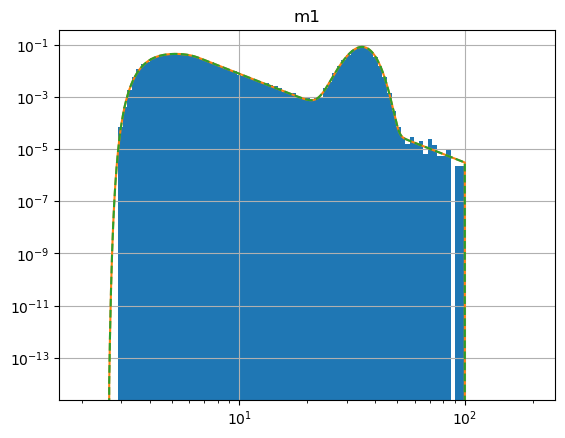

In [30]:
my_GW_sampler.BBH.hist('m1',bins = np.geomspace(2e0,2e2,100),density = True)
plt.yscale('log')
plt.xscale('log')

m_min, m_max = 2.5, 100.
ms = np.linspace(m_min,m_max,10000)
dm = ms[1]-ms[0]

args = (m_min,m_max, 3.4, 35., 3.9, 0.04, 4.8)
ps = my_GW_sampler.gaussian_plaw(ms,*args)

plt.plot(ms,ps/np.sum(ps*dm))

ps_trial = gaussian_plaw(ms,*args)

plt.plot(ms,ps_trial/np.sum(ps_trial*dm),ls='--')

## Read data

In [3]:
# Define the folder path where your CSV files are located
folder_path = "Spectral_Sirens_data/*.csv"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(folder_path)

# Read each CSV file and store in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Filters
filtpass = combined_df['PASS']
filtiner = combined_df['inversion_err'] < 0.05
filtsnrs = combined_df['snrs'] > 12
filtall  = filtpass & filtsnrs & filtiner

# Keep filtered
df = combined_df[filtall].copy()

In [4]:
combined_df['m1z'] = combined_df['m1'] * (1 + combined_df['z'])
combined_df['m2z'] = combined_df['m2'] * (1 + combined_df['z'])

In [5]:
df.reset_index(drop = True,inplace = True)
df['m1z'] = df['m1'] * (1 + df['z'])
df['m2z'] = df['m2'] * (1 + df['z'])

In [6]:
df[['m1z','m2z','dL']]

,m1z,m2z,dL
0,13.107819,6.336895,8.985339
1,13.951829,6.959246,13.114758
2,59.983311,24.005628,5.438308
3,10.427829,5.572260,2.326993
4,60.043299,10.623109,2.671096
...,...,...,...
25117,40.458913,9.083338,2.572511
25118,42.562037,6.255453,1.537235
25119,52.632256,10.243501,2.586653
25120,24.210540,11.016924,27.029349


Text(0, 0.5, 'Events')

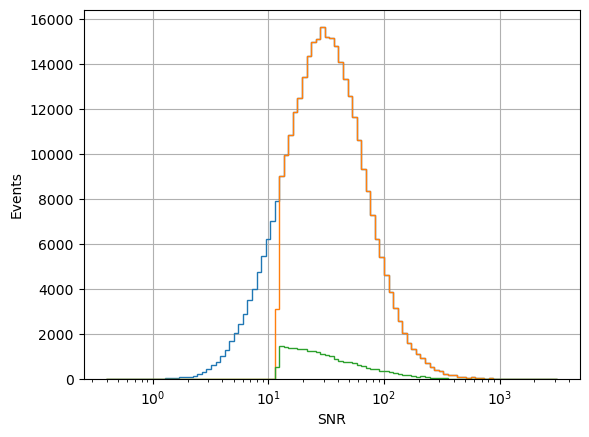

In [7]:
combined_df['snrs'].hist(bins = np.geomspace(combined_df['snrs'].min(),combined_df['snrs'].max(),100),histtype = 'step')
combined_df[filtsnrs]['snrs'].hist(bins = np.geomspace(combined_df['snrs'].min(),combined_df['snrs'].max(),100),histtype = 'step')
combined_df[filtsnrs&filtiner]['snrs'].hist(bins = np.geomspace(combined_df['snrs'].min(),combined_df['snrs'].max(),100),histtype = 'step')
plt.xscale('log')
plt.xlabel('SNR')
plt.ylabel('Events')

In [8]:
combined_df[filtiner]['sigma_phi'].max()

5666.175621317527

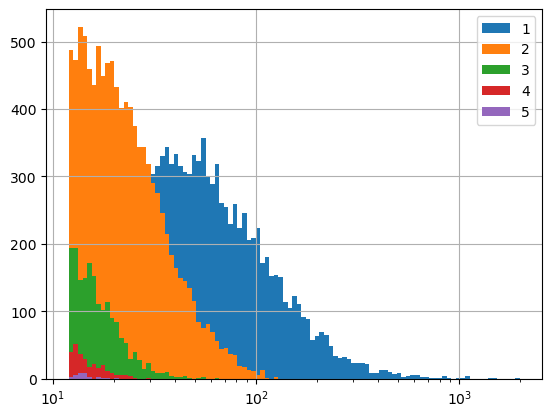

In [9]:
z_edge = [0,1,2,3,4,5]
for i in range(1,len(z_edge)):
    filtz = (df['z'] > z_edge[i-1]) & (df['z'] < z_edge[i])
    df['snrs'][filtz].hist(bins = np.geomspace(12,df['snrs'].max(),100),label = str(z_edge[i]))
plt.xscale('log')
plt.legend()

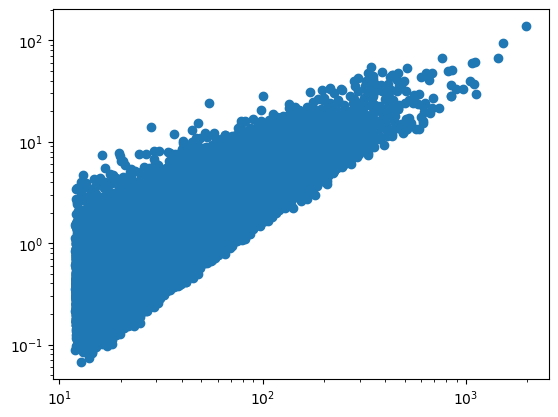

In [15]:
xs = df['snrs']
ys = (df['Mc']) / df['dL']
plt.scatter(xs,ys)
plt.xscale('log')
plt.yscale('log')

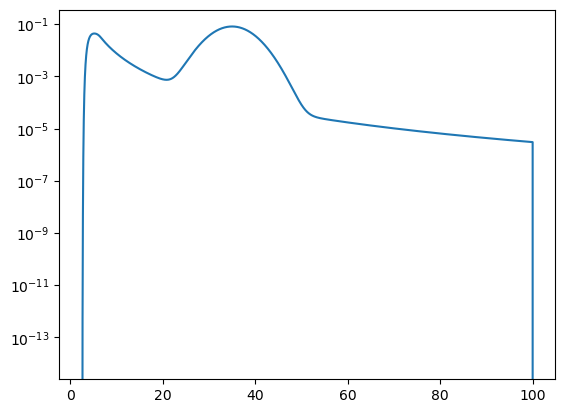

In [13]:
m_min, m_max = 2.5, 100.
ms = np.linspace(m_min,m_max,10000)
dm = ms[1]-ms[0]

args = (m_min,m_max, 3.4, 35., 3.9, 0.04, 4.8)
ps = my_GW_sampler.gaussian_plaw(ms,*args)

plt.semilogy(ms,ps/np.sum(ps*dm))

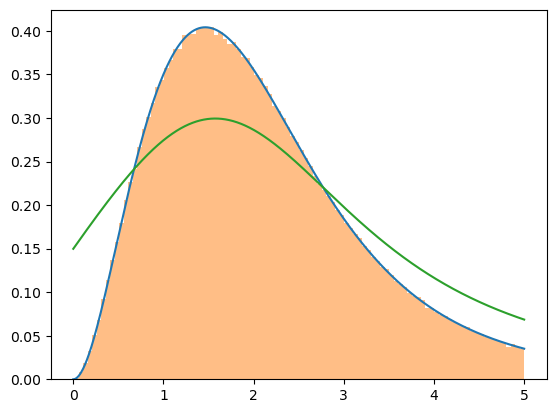

In [14]:
mysampler = RedshiftSampler(zmax = 5)

z_vals = np.linspace(0,5,1000)
dz = z_vals[1] - z_vals[0]
# R_vals = mysampler.R(z_vals)
# plt.plot(z_vals,R_vals/np.sum(R_vals*dz))

dN_gw_vals = mysampler.dN_gw(z_vals,dz,1)
plt.plot(z_vals,dN_gw_vals/np.sum(dN_gw_vals*dz))

mysampler.sample_z(n=int(1e6))

plt.hist(mysampler.host_z['z'], bins = 100, alpha = 0.5, density = True);

R_vals = mysampler.R(z_vals)
plt.plot(z_vals,R_vals/np.sum(R_vals*dz))

## GW Fast

In [8]:
class EventSimulator:
    def __init__(self, host_g, filt_snr = None, filt_err = None, batch = 50):
        self.new_cols = ['snrs','PASS','theta','phi','inversion_err','skyArea','sigma_Mc','sigma_eta','sigma_dL','sigma_theta','sigma_phi']
        self.new_cols_snr_only = ['snrs']
        self.host_g   = host_g
        self.filt_snr = filt_snr
        self.filt_err = filt_err
        self.batch    = batch
        ########################################################################
        alldetectors = copy.deepcopy(glob.detectors)
        print('All available detectors are: '+str(list(alldetectors.keys())))
    
        # select 1ET+2CE
        MYdetectors = {det:alldetectors[det] for det in ['ETMR', 'CE1Id', 'CE2NM']}
        
        # # select only ET
        # MYdetectors = {det:alldetectors[det] for det in ['ETMR']}
        
        print('Using detectors '+str(list(MYdetectors.keys())))
    
        # We use the O2 psds
        MYdetectors['ETMR']['psd_path']  = os.path.join(glob.detPath, 'ET-0000A-18.txt')
        MYdetectors['CE1Id']['psd_path'] = os.path.join(glob.detPath, 'ce_strain/cosmic_explorer_20km.txt')
        MYdetectors['CE2NM']['psd_path'] = os.path.join(glob.detPath, 'ce_strain/cosmic_explorer_20km.txt')
    
        mySignalsET = {}

        for d in MYdetectors.keys():
            mySignalsET[d] = GWSignal(
                # TaylorF2_RestrictedPN(use_3p5PN_SpinHO=True, is_tidal=True),
                IMRPhenomD(),
                # (True, True),
                        psd_path= MYdetectors[d]['psd_path'],
                        detector_shape = MYdetectors[d]['shape'],
                        det_lat= MYdetectors[d]['lat'],
                        det_long=MYdetectors[d]['long'],
                        det_xax=MYdetectors[d]['xax'],
                        verbose=True,
                        useEarthMotion = False,
                        fmin=2.,
                        IntTablePath=None)

        self.myNet = DetNet(mySignalsET)
        ########################################################################
    
    def translate(self, df, filt = np.array([])):

        if filt.size == 0:
          filt = np.full(len(df), True)
        zs       = df['z'].values[filt]
        dLs      = df['dL'].values[filt]
        Mcs      = df['Mc'].values[filt]
        etas     = df['eta'].values[filt]
        RAs      = df['ra'].values[filt]
        DECs     = df['dec'].values[filt]
        iotas    = df['iota'].values[filt]
        psis     = df['psi'].values[filt]
        tcoals   = df['tcoal'].values[filt]
        Phicoals = df['Phicoal'].values[filt]
        chi1zs   = df['chi1z'].values[filt]
        chi2zs   = df['chi2z'].values[filt]

        events = {'Mc'       : Mcs*(1.+zs),
                  'eta'      : etas,
                  'dL'       : dLs,
                  'ra'       : RAs,
                  'dec'      : DECs,
                  'iota'     : iotas,
                  'psi'      : psis,
                  'tcoal'    : tcoals,
                  'Phicoal'  : Phicoals,
                  'chi1z'    : chi1zs,
                  'chi2z'    : chi2zs,
                  'Lambda1'  : np.zeros(np.sum(filt)),
                  'Lambda2'  : np.zeros(np.sum(filt))
                  }
        return events


    def simulate_batch(self, df, snr_only = False):

        nevents = len(df)

        events = self.translate(df.copy())

        ####### SNR
        snrs = self.myNet.SNR(events)
        df['snrs'] = snrs

        if self.filt_snr != None:
          filtered_snr = snrs > self.filt_snr
          print(np.sum(~filtered_snr), 'out of', len(snrs),'dropped by SNR:',np.sum(filtered_snr), 'passed.')
          
          snrs = snrs[filtered_snr]
          events = self.translate(df.copy(), filtered_snr)
        else:
          filtered_snr = np.full(nevents, True)

        ####### INVERSION ERROR
        if not snr_only:
            totF = self.myNet.FisherMatr(events)
            totCov, inversion_err = CovMatr(totF)
    
            if self.filt_err != None:
              filtered_err = inversion_err < self.filt_err
              print(np.sum(~filtered_err), 'out of', len(snrs),'dropped by inversion error:', np.sum(filtered_err), 'passed.')
            else:
              filtered_err = np.full(len(snrs), True)

            ####### PASS OR NOT COLUMN
            df['PASS'] = filtered_snr
            df.loc[filtered_snr,'PASS'] = filtered_err
        
            ####### SAVE
            ParNums = IMRPhenomD().ParNums #IMRPhenomD_NRTidalv2
            skyArea = compute_localization_region(totCov, ParNums, events['theta'],units = 'Sterad')
    
            df.loc[filtered_snr,'theta']          = events['theta']
            df.loc[filtered_snr,'phi']            = events['phi']
            df.loc[filtered_snr,'snrs']           = snrs
            df.loc[filtered_snr,'inversion_err']  = inversion_err
            df.loc[filtered_snr,'skyArea']        = skyArea
    
            for key in ['Mc', 'eta', 'dL', 'theta', 'phi']:
              df.loc[filtered_snr,'sigma_'+key] = np.sqrt(np.diagonal(totCov))[:,ParNums[key]]

            return df[self.new_cols]
        
        
        else:
            ####### PASS OR NOT COLUMN
            df['PASS'] = filtered_snr
            # df.loc[filtered_snr,'PASS'] = filtered_err
            
            ####### SAVE
            ParNums = IMRPhenomD().ParNums #IMRPhenomD_NRTidalv2
            # skyArea = compute_localization_region(totCov, ParNums, events['theta'],units = 'Sterad')
    
            # df.loc[filtered_snr,'theta']          = events['theta']
            # df.loc[filtered_snr,'phi']            = events['phi']
            df.loc[filtered_snr,'snrs']           = snrs
            # df.loc[filtered_snr,'inversion_err']  = inversion_err
            # df.loc[filtered_snr,'skyArea']        = skyArea
    
            # for key in ['Mc', 'eta', 'dL', 'theta', 'phi']:
            #   df.loc[filtered_snr,'sigma_'+key] = np.sqrt(np.diagonal(totCov))[:,ParNums[key]]

            return df[self.new_cols_snr_only]
            



    def simulate(self, nevents = None, snr_only = False):
        if nevents == None:
            nevents = len(self.host_g)
        """Splits host_g into batches and processes each using simulate_batch()."""
        
        batch_size = self.batch

        for start in range(0, nevents, batch_size):
            end = min(start + batch_size, nevents)
            batch_indices = self.host_g.index[start:end]

            print(f"Processing batch {start} to {end} (out of {nevents})")
            if not snr_only:
                temp_df = self.simulate_batch(self.host_g.loc[batch_indices].copy(),snr_only = snr_only)  # Call simulate for each batch
                self.host_g.loc[batch_indices,self.new_cols] = temp_df
            else:
                temp_df = self.simulate_batch(self.host_g.loc[batch_indices].copy(),snr_only = snr_only)  # Call simulate for each batch
                self.host_g.loc[batch_indices, self.new_cols_snr_only] = temp_df
            
        print("All batches processed successfully!")


        return None

In [9]:
#EXAMPLE USAGE

In [1]:
from Event_Simulator import GWSampler,RedshiftSampler,EventSimulator

TEOBResumS is not installed, only the GWFAST waveform models are available, namely: TaylorF2, IMRPhenomD, IMRPhenomD_NRTidalv2, IMRPhenomHM and IMRPhenomNSBH
Available devices: [cuda(id=0)]


In [2]:
N_events = int(1e5)

# Set z sampler with given cosmo
my_z_sampler = RedshiftSampler(zmin = 0,zmax = 10, H0 = 70., Om0 = 0.3)

# Obtain host redshifts
my_z_sampler.sample_z(n = N_events)

# Feed host_z to GWSampler
my_GW_sampler = GWSampler(host_g = my_z_sampler.host_z.copy()) #add .copy() if not want to influence host_z df

# Sample astrophysical parameters for BBH
my_GW_sampler.sample_BBH()

# Show BBHs
my_GW_sampler.BBH

Change n to comply with host_g.


/gpfs/home3/iliodis/SBI/Event_Simulator.py:41: RuntimeWarning: overflow encountered in exp
  return (1 + np.exp(delta/m + delta/(m - delta)))**(-1)


,z,dL,ra,dec,m1,m2,eta,Mc,iota,psi,tcoal,Phicoal,chi1z,chi2z
0,1.267495,8.859541,4.935613,0.443599,31.224514,5.028927,0.119474,10.132410,1.186649,3.214853,0.821893,0.079152,-0.504774,0.203292
1,2.383680,19.249717,4.114904,0.731988,6.036933,4.281396,0.242763,4.412850,2.272604,1.593876,0.337763,1.472681,-0.557895,-0.080631
2,1.587261,11.697727,5.826955,-1.145718,31.109928,27.749674,0.249185,25.569997,2.304319,0.368049,0.877234,4.799955,0.704159,0.280195
3,0.858959,5.476883,5.960670,-0.247612,34.142721,24.014198,0.242417,24.850747,1.624850,4.188828,0.625515,2.057297,0.154090,0.389809
4,2.192457,17.385957,2.823165,0.748922,36.693080,13.737007,0.198197,19.096238,1.268511,1.481053,0.193014,3.095038,0.292744,-0.590904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.853368,5.432987,0.357705,0.195994,36.208777,24.208286,0.240137,25.670529,1.765631,4.644757,0.426254,3.456783,-0.180635,-0.421480
99996,4.013755,35.998148,1.133073,0.462878,35.062055,31.513629,0.249290,28.929328,2.460700,6.208254,0.934899,3.706487,-0.439775,0.228698
99997,0.888179,5.707499,5.605982,-0.638654,38.134261,8.862018,0.153010,15.236881,0.877535,3.859738,0.443174,6.167073,-0.714634,0.413048
99998,1.597511,11.790906,1.114909,1.223273,8.506953,4.805483,0.230673,5.521475,0.966323,6.010885,0.725749,2.393535,-0.055689,-0.135532


In [3]:
my_event_simulator = EventSimulator(my_GW_sampler.BBH[:100].copy(), filt_snr = 12., filt_err = 0.05, batch = 100)

All available detectors are: ['L1', 'H1', 'Virgo', 'KAGRA', 'LIGOI', 'ETS', 'ETMR', 'ETSL', 'ETMRL45d', 'ETMRLpar', 'CE1Id', 'CE2NM', 'CE2NSW']
Using detectors ['ETMR', 'CE1Id', 'CE2NM']
Using ASD from file /home/iliodis/.local/lib/python3.11/site-packages/psds/ET-0000A-18.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1


2025-06-03 10:29:45.182643: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.7 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Using ASD from file /home/iliodis/.local/lib/python3.11/site-packages/psds/ce_strain/cosmic_explorer_20km.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1
Using ASD from file /home/iliodis/.local/lib/python3.11/site-packages/psds/ce_strain/cosmic_explorer_20km.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1


In [4]:
my_event_simulator.simulate()

Processing batch 0 to 100 (out of 100)
Adding (theta, phi) from (ra, dec)
3 out of 100 dropped by SNR: 97 passed.
Adding (theta, phi) from (ra, dec)
Computing Fisher for ETMR...
Computing derivatives...
Filling matrix for arm 1...
Computing derivatives...
Filling matrix for arm 2...
Filling matrix for arm 3...
Computing Fisher for CE1Id...
Computing derivatives...
Computing Fisher for CE2NM...
Computing derivatives...
Done.
0 out of 97 dropped by inversion error: 97 passed.
All batches processed successfully!


In [5]:
my_event_simulator.host_g.inversion_err #inspection

0     9.319047e-08
1     1.580920e-07
2     3.728201e-08
3     1.230364e-08
4     8.474217e-10
          ...     
95    4.096364e-08
96    1.964509e-08
97    2.054367e-08
98    1.084700e-07
99    1.860462e-08
Name: inversion_err, Length: 100, dtype: float64

In [6]:
# my_event_simulator.host_g.PASS.sum()/len(my_event_simulator.host_g)

## Generate mock data and save

In [17]:
my_GW_sampler.BBH

,z,dL,ra,dec,m1,m2,eta,Mc,iota,psi,tcoal,Phicoal,chi1z,chi2z
0,1.916486,14.748455,3.081135,-0.455623,36.238202,12.876504,0.193438,18.328902,0.928283,4.639706,0.313341,3.223462,0.055172,-0.242025
1,1.817952,13.823545,1.058395,-0.353061,5.123584,4.228689,0.247711,4.048408,1.957784,5.415844,0.989349,3.499029,-0.183547,0.456836
2,1.961007,15.169414,4.957012,0.093305,38.103864,27.543817,0.243531,28.128852,2.095252,2.893569,0.590085,2.725691,-0.258474,0.404827
3,2.050109,16.017281,3.855304,0.401325,32.269571,29.718822,0.249577,26.954594,2.683255,0.162466,0.573912,6.268688,-0.443090,-0.454599
4,2.845214,23.851063,1.473358,0.213989,31.739932,25.165504,0.246663,24.570626,0.595689,0.412899,0.778228,5.538970,-0.403833,-0.414606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.352430,1.872019,2.867635,0.142136,23.294455,6.737329,0.174012,10.517874,1.441937,0.670507,0.178187,1.038950,-0.294214,-0.468237
999996,1.883752,14.440144,3.181522,-0.216771,38.121334,17.836591,0.217148,22.382863,0.138610,1.227536,0.917538,6.066280,-0.349350,-0.171745
999997,2.019366,15.723946,1.077275,0.763118,30.584237,12.039670,0.202678,16.358244,0.468896,0.092164,0.804712,2.065089,-0.095278,-0.091936
999998,1.631342,12.099337,0.807393,0.282056,35.251084,21.605906,0.235601,23.883073,1.358411,5.984771,0.672468,2.484044,-0.275882,0.136095


In [ ]:
start_point = 0
batch_size = 5000
# end_limit = 100
end_limit = len(my_GW_sampler.BBH)  # Total length of BBH dataset

for start in tqdm(range(start_point, end_limit, batch_size), desc="Processing batches"):
    
    end = min(start + batch_size, end_limit)
    
    my_event_simulator = EventSimulator(
        my_GW_sampler.BBH[start:end].copy(), filt_snr=12, filt_err=0.05, batch=100
    )
    my_event_simulator.simulate()
    
    # Convert to DataFrame and save
    df = pd.DataFrame(my_event_simulator.host_g)
    df.to_csv(f"Fisher_data_1ET2CE/spec_data_{start}_{end}.csv", index=False)
    
    print(f"Saved: host_g_{start}_{end}.csv")


Processing batches:   0%|          | 0/20 [00:00<?, ?it/s]

All available detectors are: ['L1', 'H1', 'Virgo', 'KAGRA', 'LIGOI', 'ETS', 'ETMR', 'ETSL', 'ETMRL45d', 'ETMRLpar', 'CE1Id', 'CE2NM', 'CE2NSW']
Using detectors ['ETMR', 'CE1Id', 'CE2NM']
Using ASD from file /home/iliodis/.local/lib/python3.11/site-packages/psds/ET-0000A-18.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1
Using ASD from file /home/iliodis/.local/lib/python3.11/site-packages/psds/ce_strain/cosmic_explorer_20km.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1
Using ASD from file /home/iliodis/.local/lib/python3.11/site-packages/psds/ce_strain/cosmic_explorer_20km.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1
Processing batch 0 to 100 (out of 5000)
Adding (theta, phi) from (ra, dec)
3 out of 100 dropped by SNR: 97 passed.
Adding (theta, phi) from (ra, dec)
Computing Fisher for ETMR...
Computing derivatives...
Filling matrix for arm 1...
Computing derivatives...
Filling matrix for arm 2...
Filling matri